<a href="https://colab.research.google.com/github/sruthich1408/FMML-LABS/blob/main/Module_7_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 7 Project: Movie Recommendation Engine

`Module Coordinator: Ganesh Chandan`

In this module, we will try to create a Movie Recommendation System using different unsupervised learning techniques.

In [1]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-02-07 09:35:32--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.32MB/s    in 0.3s    

2025-02-07 09:35:32 (3.32 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Clustering based recommendation

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [6]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [7]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


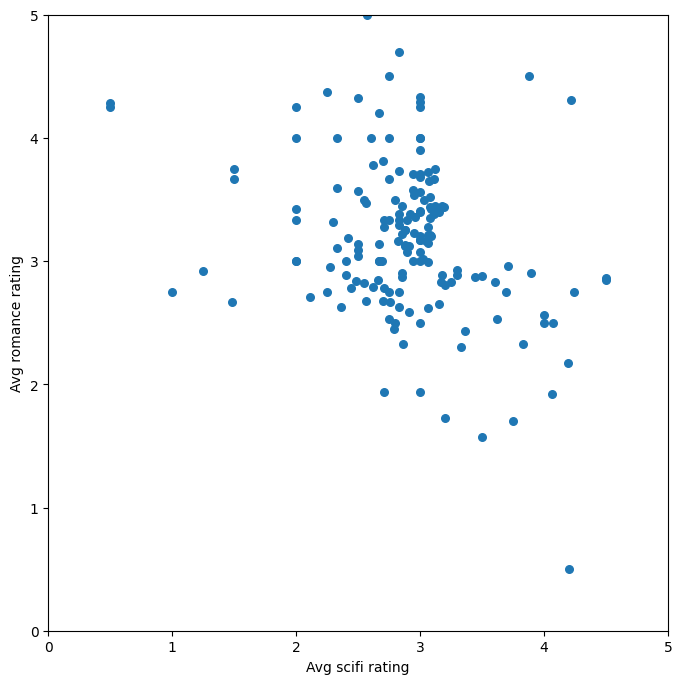

In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

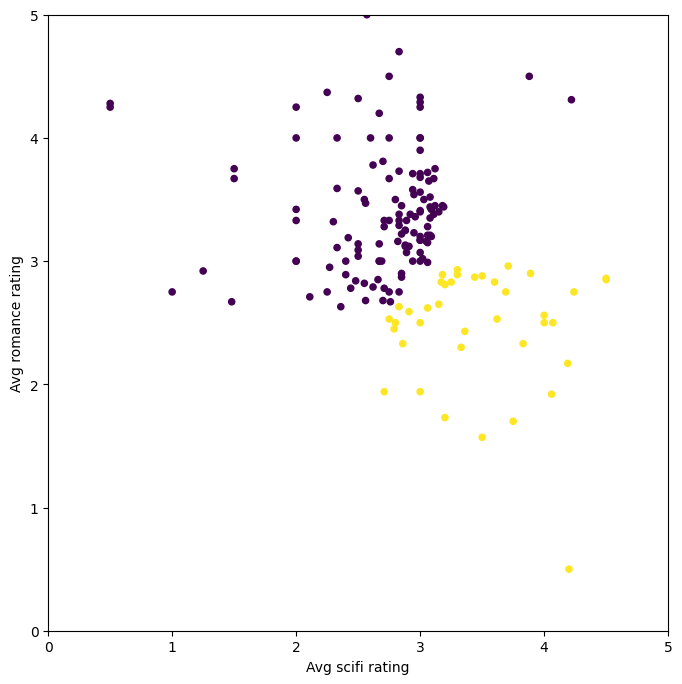

In [9]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

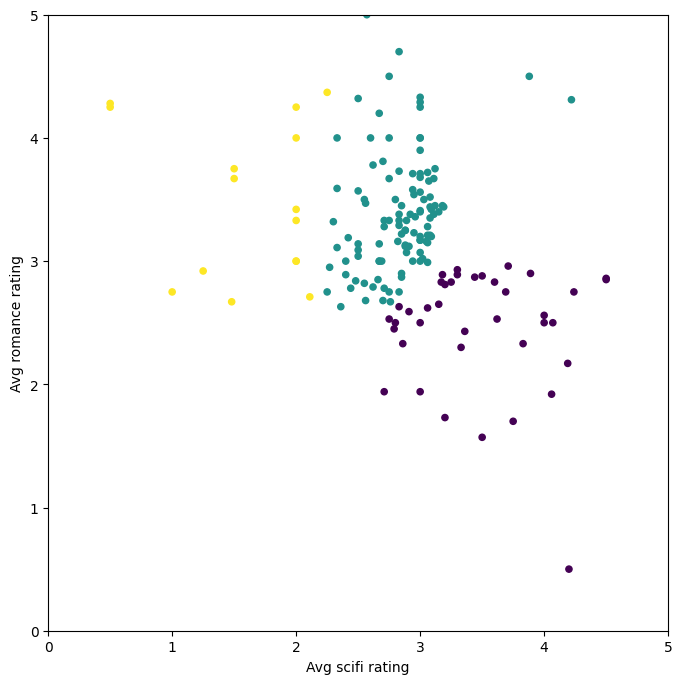

In [10]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

It is evident now that the science-fiction rating has started to come into play:

    People who like sci-fi and romance modeately belong to the green group.
    People who like scifi but not romance belong to the yello group.
    People who like romance but not sci-fi belong to the purple group.

Finding optimal clusters using silhouette score

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


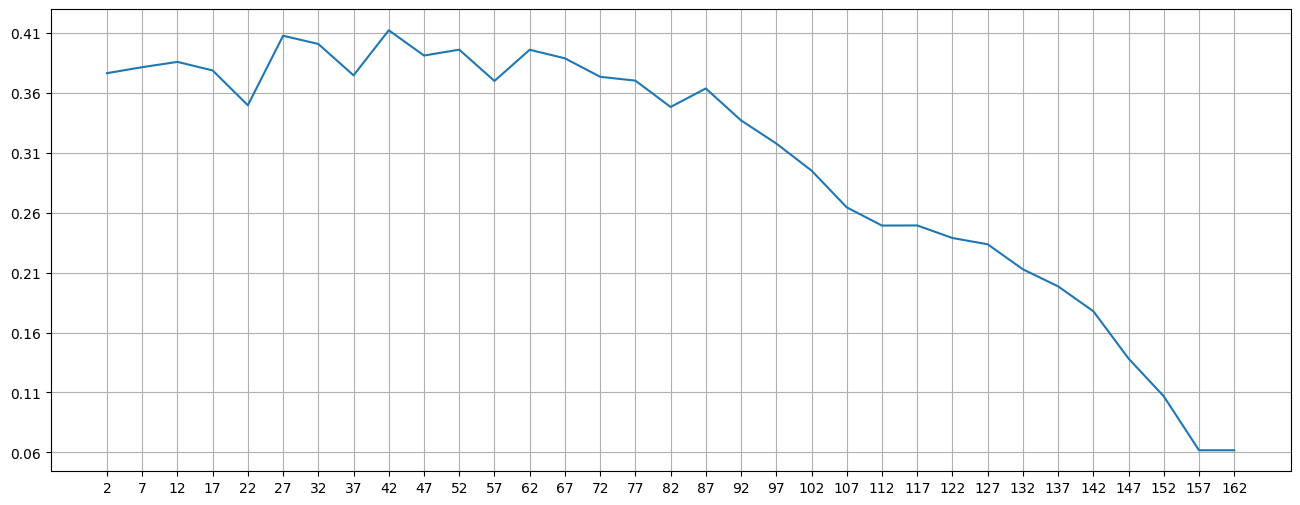

In [11]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



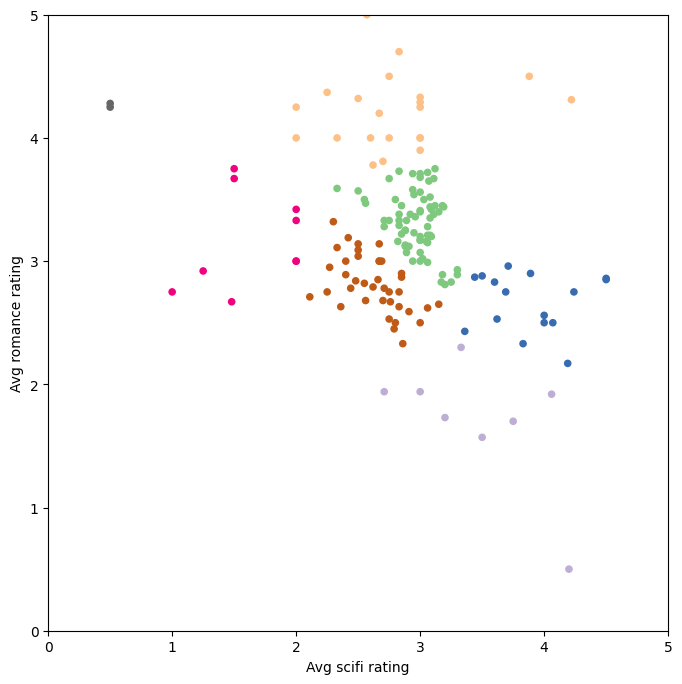

In [12]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [13]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


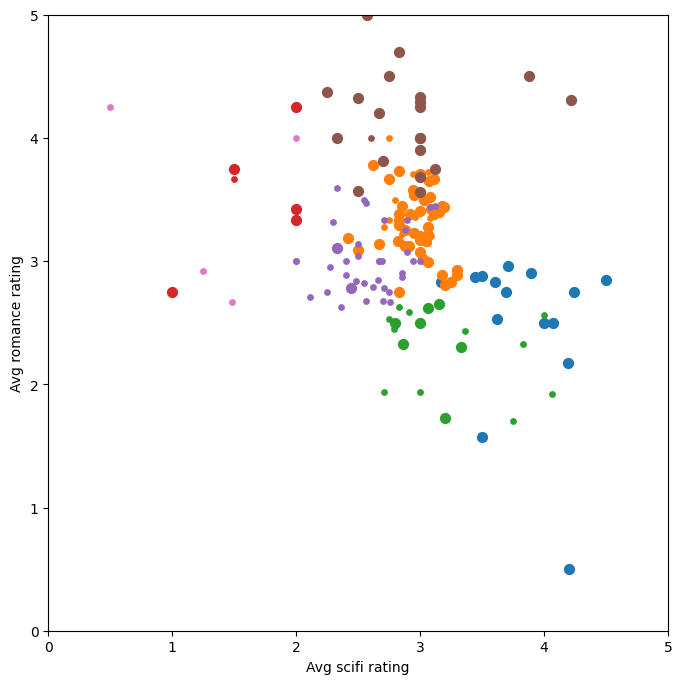

In [14]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

The size of the dots represent the ratings of the action movies.

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

In [15]:
# CODE

### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [16]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
import pandas as pd

# Define function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count ratings per movie
    user_movie_ratings.loc['count'] = user_movie_ratings.count()

    # 2- Sort movies by number of ratings (descending)
    user_movie_ratings_sorted = user_movie_ratings.sort_values(by='count', axis=1, ascending=False)

    # 3- Drop the count row
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(index='count')

    # 4- Select top movies
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]

    return most_rated_movies

# Define function to get users who rate the most
def get_users_who_rate_the_most(most_rated_movies, n_users):
    # Count the number of ratings per user
    most_rated_movies = most_rated_movies.copy()  # Avoid modifying original data
    most_rated_movies['num_ratings'] = most_rated_movies.notnull().sum(axis=1)

    # Sort users by number of ratings (descending)
    most_rated_movies = most_rated_movies.sort_values(by='num_ratings', ascending=False)

    # Select top users and drop the helper column
    most_rated_movies = most_rated_movies.iloc[:n_users, :].drop(columns=['num_ratings'])

    return most_rated_movies

# Define function to sort dataset by rating density
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

# Choose the number of movies and users
n_movies = 30
n_users = 18

# Ensure 'user_movie_ratings' is defined and is a DataFrame
if 'user_movie_ratings' not in locals() or not isinstance(user_movie_ratings, pd.DataFrame):
    raise ValueError("Error: 'user_movie_ratings' must be a defined Pandas DataFrame.")

# Apply sorting
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

# Print results
print(f"Dataset dimensions: {most_rated_movies_users_selection.shape}")
print(most_rated_movies_users_selection.head())


Dataset dimensions: (18, 30)
title   Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
userId                                                          
414                     5.0                               5.0   
590                     5.0                               4.5   
474                     3.0                               5.0   
480                     5.0                               5.0   
68                      3.5                               3.0   

title   Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
userId                                                          
414                     5.0                               4.0   
590                     4.5                               3.5   
474                     4.0                               4.5   
480                     4.0                               4.5   
68                      2.0                               3.5   

title   Matrix, The (1999)  Star Wars: Episode IV - A New H

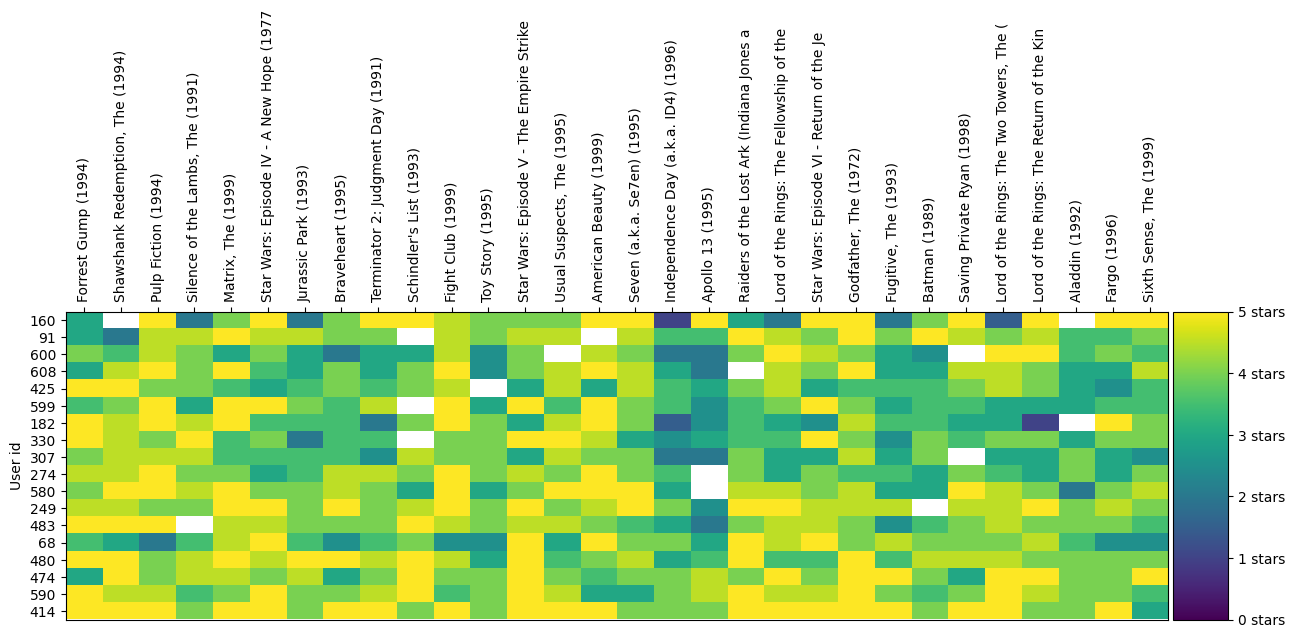

In [90]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [91]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).replace(np.nan, 0)

In [92]:
from scipy import sparse
import pandas as pd

# Ensure 'most_rated_movies_1k' exists and is valid
if 'most_rated_movies_1k' not in locals() or not isinstance(most_rated_movies_1k, pd.DataFrame):
    raise ValueError("Error: 'most_rated_movies_1k' must be a defined Pandas DataFrame.")

# Convert to sparse csr matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

# Check the shape of the sparse matrix to verify successful conversion
print(f"Successfully converted to sparse matrix with shape: {sparse_ratings.shape}")


Successfully converted to sparse matrix with shape: (610, 1000)


### Large Scale Clustering

In [118]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# Mock definitions for demonstration purposes
# Replace these with your actual data and functions
sparse_ratings = csr_matrix(np.random.rand(100, 50))  # Example sparse matrix with 100 users and 50 movies
user_movie_ratings = pd.DataFrame(np.random.randint(1, 6, size=(100, 50)), columns=[f'Movie_{i}' for i in range(50)])

def get_most_rated_movies(user_movie_ratings, top_n):
    # This function should return the top_n most rated movies
    return user_movie_ratings.mean(axis=0).nlargest(top_n).reset_index()

def draw_movie_clusters(clustered, max_users, max_movies):
    # This function should visualize the clustered data
    print("Drawing movie clusters...")  # Placeholder for actual drawing logic

# Validate 'sparse_ratings'
if 'sparse_ratings' not in locals() or sparse_ratings is None:
    raise ValueError("Error: 'sparse_ratings' is not defined or is None.")
if not isinstance(sparse_ratings, (np.ndarray, csr_matrix)):
    raise TypeError("Error: 'sparse_ratings' must be a NumPy array or a SciPy sparse matrix.")

# Validate 'user_movie_ratings'
if 'user_movie_ratings' not in locals() or not isinstance(user_movie_ratings, pd.DataFrame):
    raise ValueError("Error: 'user_movie_ratings' is not defined or is not a valid DataFrame.")

# Ensure 'sparse_ratings' has the correct number of rows
if sparse_ratings.shape[0] != user_movie_ratings.shape[0]:
    raise ValueError("Error: 'sparse_ratings' must have the same number of rows as 'user_movie_ratings'.")

# Apply KMeans clustering
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)  # Explicitly setting n_init for newer sklearn versions
predictions = kmeans.fit_predict(sparse_ratings)

# Validate and call 'get_most_rated_movies'
if 'get_most_rated_movies' not in globals() or not callable(get_most_rated_movies):
    raise ValueError("Error: 'get_most_rated_movies' function is not defined or not callable.")

try:
    most_rated_movies = get_most_rated_movies(user_movie_ratings, 10).reset_index(drop=True)  # Adjusted to return 10 for demonstration
except Exception as e:
    raise RuntimeError(f"Error while executing 'get_most_rated_movies': {e}")

# Ensure predictions match the number of users
if len(predictions) != len(user_movie_ratings):
    raise ValueError(f"Error: Mismatch in predictions ({len(predictions)}) and users ({len(user_movie_ratings)}).")

# Create DataFrame for clustered results
clustered = pd.concat([most_rated_movies, pd.DataFrame({'group': predictions})], axis=1)

# Set default values for 'max_users' and 'max_movies' if not defined
max_users = locals().get('max_users', 50)
max_movies = locals().get('max_movies', 50)

# Validate and call 'draw_movie_clusters'
if 'draw_movie_clusters' in globals() and callable(draw_movie_clusters):
    try:
        draw_movie_clusters(clustered, max_users, max_movies)
    except Exception as e:
        print(f"❌ Error while executing 'draw_movie_clusters': {e}")
else:
    print("⚠️ Warning: 'draw_movie_clusters' function is not defined or is not callable.")

Drawing movie clusters...


### Predictions and Recommendation

In [28]:
# Ensure 'clustered' DataFrame is defined before accessing it
if 'clustered' not in globals():
    print("Error: 'clustered' DataFrame is not defined.")
else:
    # Pick a cluster ID from the clusters above
    cluster_number = 11

    # Check if cluster_number exists in 'clustered.group'
    if cluster_number not in clustered['group'].unique():
        print(f"Error: Cluster ID {cluster_number} not found in 'clustered' DataFrame.")
    else:
        # Define user and movie limits
        n_users = 75
        n_movies = 300

        # Filter dataset based on selected cluster
        cluster = clustered[clustered['group'] == cluster_number]

        # Ensure columns exist before dropping
        drop_columns = [col for col in ['index', 'group'] if col in cluster.columns]
        cluster = cluster.drop(drop_columns, axis=1)

        # Print the filtered cluster
        print("Filtered Cluster Data:")
        print(cluster.head())

        # Ensure sort_by_rating_density() is defined before calling
        if 'sort_by_rating_density' in globals():
            cluster = sort_by_rating_density(cluster, n_movies, n_users)
        else:
            print("Error: The function 'sort_by_rating_density()' is not defined.")

        # Ensure draw_movies_heatmap() is defined before calling
        if 'draw_movies_heatmap' in globals():
            draw_movies_heatmap(cluster, axis_labels=False)
        else:
            print("Error: The function 'draw_movies_heatmap()' is not defined.")


Error: 'clustered' DataFrame is not defined.


In [30]:
# Ensure 'cluster' DataFrame is defined before accessing it
if 'cluster' not in globals():
    print("Error: 'cluster' DataFrame is not defined.")
else:
    # Fill in the name of the column/movie
    movie_name = "Matrix, The (1999)"

    # Check if the movie exists in the dataset
    if movie_name not in cluster.columns:
        print(f"Error: Movie '{movie_name}' not found in the dataset.")
    else:
        # Compute and display the mean rating, ignoring NaN values
        mean_rating = cluster[movie_name].dropna().mean()
        print(f"Average rating for '{movie_name}': {mean_rating:.2f}")


Error: 'cluster' DataFrame is not defined.


In [32]:
# Ensure 'cluster' DataFrame is defined before accessing it
if 'cluster' not in globals():
    print("Error: 'cluster' DataFrame is not defined.")
elif not isinstance(cluster, pd.DataFrame):
    print("Error: 'cluster' is not a valid DataFrame.")
else:
    # Compute the mean rating for each movie, ignoring non-numeric columns
    cluster_means = cluster.mean(numeric_only=True)

    # Display the first 20 results, handling cases where there are fewer than 20 movies
    if cluster_means.empty:
        print("Error: No numeric data available in 'cluster' to compute mean ratings.")
    else:
        print("Mean ratings of the first 20 movies:")
        print(cluster_means.head(20))


Error: 'cluster' DataFrame is not defined.


In [34]:
# Ensure 'cluster' is defined before printing
if 'cluster' not in globals():
    print("Error: 'cluster' DataFrame is not defined.")
elif not isinstance(cluster, pd.DataFrame):
    print("Error: 'cluster' is not a valid DataFrame.")
elif cluster.empty:
    print("Warning: 'cluster' DataFrame is empty.")
else:
    print(cluster.head())  # Show the first few rows


Error: 'cluster' DataFrame is not defined.


In [27]:
import pandas as pd

# Ensure the 'cluster' DataFrame is defined before accessing it
if 'cluster' not in globals():
    print("Error: 'cluster' DataFrame is not defined.")
else:
    # Pick a user ID from the dataset
    user_id = 7

    # Ensure 'cluster' is indexed by user ID
    if user_id not in cluster.index:
        print(f"Error: User ID {user_id} not found in the dataset.")
    else:
        # Get all ratings for the user
        user_2_ratings = cluster.loc[user_id, :]

        # Identify unrated movies
        user_2_unrated_movies = user_2_ratings[user_2_ratings.isnull()]

        if user_2_unrated_movies.empty:
            print(f"User {user_id} has rated all movies. No recommendations available.")



Error: 'cluster' DataFrame is not defined.


## Using Collaborative Filtering (With fast.ai)

In [35]:
import os
if os.path.exists("/content"):
    !pip install -Uqq fastai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.2 MB/s eta 0:00:00


In [36]:
from fastai.tabular.all import TabularDataLoaders, tabular_learner
from fastai.collab import CollabDataLoaders, collab_learner


### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [37]:
# Import necessary FastAI modules
from fastai.data.all import URLs, untar_data

# Download and extract the MovieLens 100K dataset
try:
    path = untar_data(URLs.ML_100k)
    print(f"Dataset downloaded at: {path}")
except Exception as e:
    print(f"Error downloading dataset: {e}")


Dataset downloaded at: /root/.fastai/data/ml-100k


The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [38]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [39]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Next we merge it to our ratings table:

In [40]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [41]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [42]:
dls.show_batch()

,user,title,rating
0,348,"Devil's Own, The (1997)",4
1,540,"Devil's Own, The (1997)",3
2,614,Mission: Impossible (1996),2
3,222,Die Hard: With a Vengeance (1995),3
4,290,"Aristocats, The (1970)",3
5,763,Rebecca (1940),4
6,786,Old Yeller (1957),4
7,536,Searching for Bobby Fischer (1993),3
8,707,Babe (1995),5
9,108,"Time to Kill, A (1996)",3


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [43]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [44]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.894582,0.959615,00:08
1,0.687770,0.909139,00:07
2,0.515963,0.878529,00:07
3,0.458074,0.861386,00:07
4,0.448999,0.857662,00:07


Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

### Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [45]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [46]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [47]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [48]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3296), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.3139),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.3097), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.2941), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2876), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2791),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2778), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2695), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2513), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2447), 'Spice World (1997)', 2.1153846153846154),
 (tensor(-0.2416), 'Harriet the Spy (1996)', 2.7),
 (tensor(-0.2400), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2327), 'Hellraiser: Bloodline (1996)', 2.0),
 (tensor(-0.2314), 'Halloween: The Curse of Michael Myers (1995)', 2.2),
 (tensor(-0.2298), 'Bio-Dome (1996)', 1.9

Or the ones with the best bias:

In [49]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5851), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5691), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5432), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5199), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5149), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5141), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5074), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4973), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4905), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4891), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4863), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.4747), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4481), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4474),
  'Wallace & Gromit: The Best of Aardman Animation (1996)',
  4.447761194029851),
 (tensor(0.4364), 'Raiders of the Lost Ark (1981)', 4.252380

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [50]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [51]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [52]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [65]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1459), 'Braveheart (1995)'),
 (tensor(1.0658), 'Forrest Gump (1994)'),
 (tensor(1.0491), 'Titanic (1997)'),
 (tensor(1.0207), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9821), 'Time to Kill, A (1996)'),
 (tensor(0.8890), 'While You Were Sleeping (1995)'),
 (tensor(0.8887), 'Pretty Woman (1990)'),
 (tensor(0.8531), 'American President, The (1995)'),
 (tensor(0.8490), 'E.T. the Extra-Terrestrial (1982)'),
 (tensor(0.8125), 'Independence Day (ID4) (1996)')]

And the worst:

In [64]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8661), 'Trainspotting (1996)'),
 (tensor(-0.8212), 'Brazil (1985)'),
 (tensor(-0.7759), 'Jade (1995)'),
 (tensor(-0.7608), 'Serial Mom (1994)'),
 (tensor(-0.7395), 'Three Colors: Blue (1993)'),
 (tensor(-0.7252), 'Sweet Hereafter, The (1997)'),
 (tensor(-0.7118), 'Boogie Nights (1997)'),
 (tensor(-0.7072), 'Dracula: Dead and Loving It (1995)'),
 (tensor(-0.7027), 'Crumb (1994)'),
 (tensor(-0.7003), 'Spice World (1997)')]

Same thing for our second dimension:

In [57]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [63]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1459), 'Braveheart (1995)'),
 (tensor(1.0658), 'Forrest Gump (1994)'),
 (tensor(1.0491), 'Titanic (1997)'),
 (tensor(1.0207), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9821), 'Time to Kill, A (1996)'),
 (tensor(0.8890), 'While You Were Sleeping (1995)'),
 (tensor(0.8887), 'Pretty Woman (1990)'),
 (tensor(0.8531), 'American President, The (1995)'),
 (tensor(0.8490), 'E.T. the Extra-Terrestrial (1982)'),
 (tensor(0.8125), 'Independence Day (ID4) (1996)')]

In [62]:
from operator import itemgetter

# Ensure 'movie_comp' is a list of tuples or sortable structure
if isinstance(movie_comp, list):
    sorted_movies = sorted(movie_comp, key=itemgetter(0))[:10]
    print(sorted_movies)
else:
    print("Error: 'movie_comp' must be a list of tuples or a sortable structure.")


[(tensor(-0.8661), 'Trainspotting (1996)'), (tensor(-0.8212), 'Brazil (1985)'), (tensor(-0.7759), 'Jade (1995)'), (tensor(-0.7608), 'Serial Mom (1994)'), (tensor(-0.7395), 'Three Colors: Blue (1993)'), (tensor(-0.7252), 'Sweet Hereafter, The (1997)'), (tensor(-0.7118), 'Boogie Nights (1997)'), (tensor(-0.7072), 'Dracula: Dead and Loving It (1995)'), (tensor(-0.7027), 'Crumb (1994)'), (tensor(-0.7003), 'Spice World (1997)')]


And we can even plot the movies according to their scores on those dimensions:

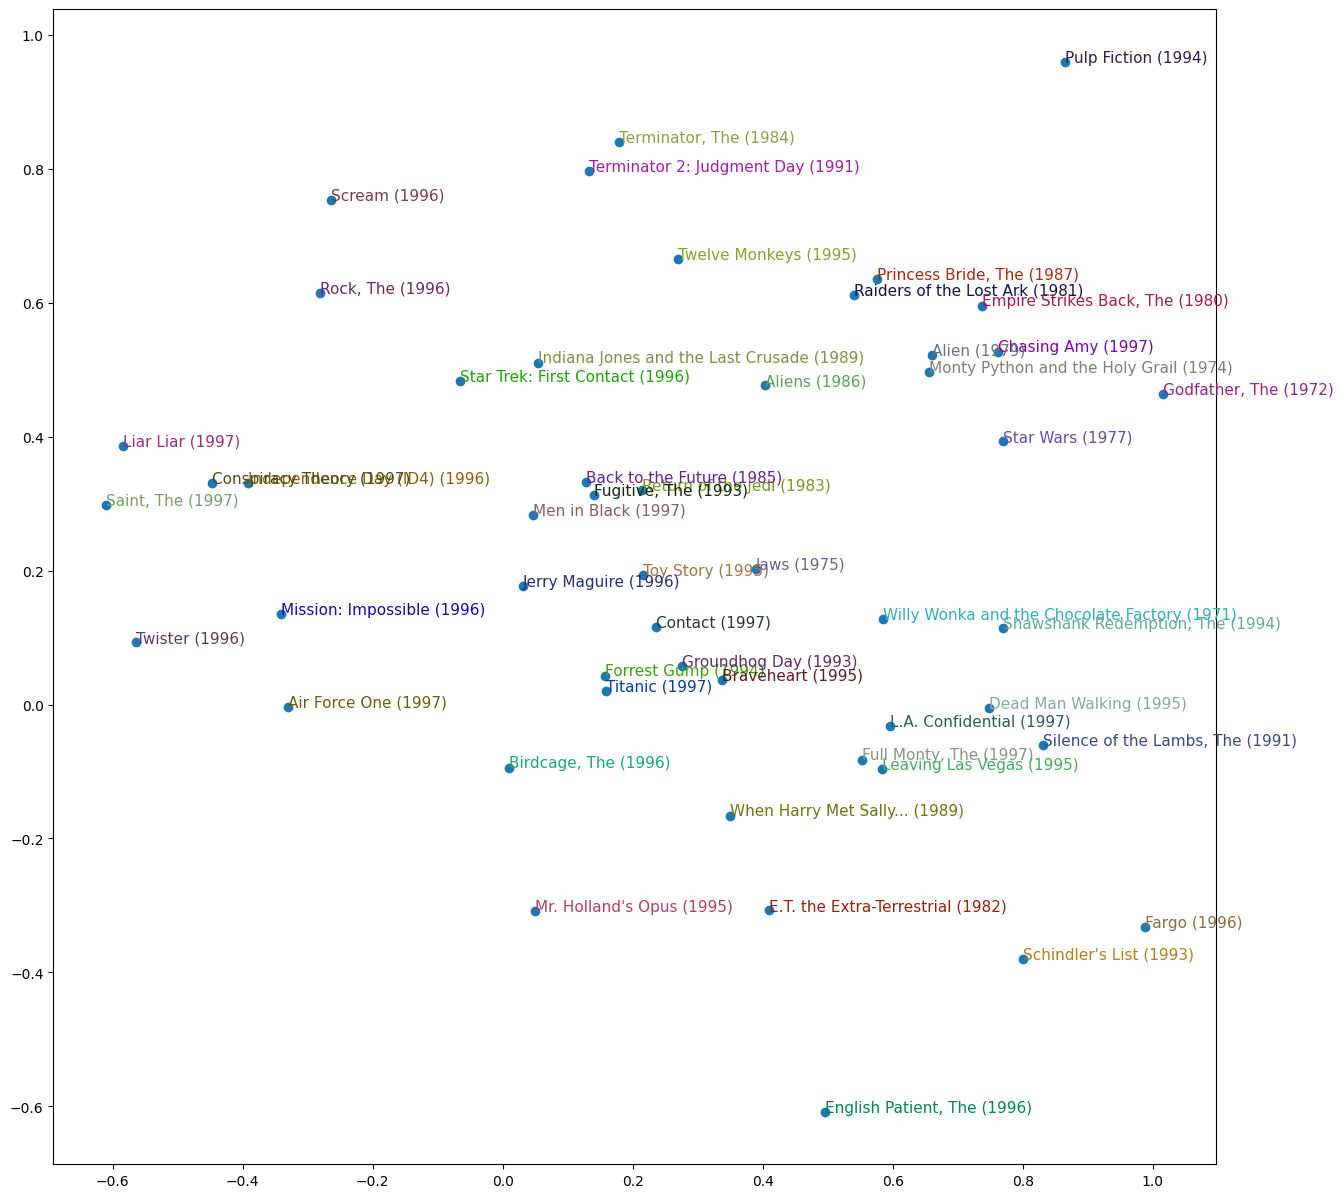

In [60]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
## Identify if any such parameters have impact on the speed of convergence or the performance on the model

Exercise 2: Exploring Collaborative Filtering Model Parameters
Collaborative filtering models, particularly Matrix Factorization-based approaches (e.g., SVD, NMF, FastAI’s Collaborative Filtering), rely on several hyperparameters that influence both convergence speed and model performance.


 Step 1: Baseline Model in FastAI
python
Copy
Edit



In [109]:
# from fastai.collab import *
from fastai.tabular.all import *

# Load dataset
path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['user', 'item', 'rating', 'timestamp'])
ratings = ratings.drop(columns=['timestamp'])

# Convert to DataLoaders
dls = CollabDataLoaders.from_df(ratings, user_name='user', item_name='item', rating_name='rating', bs=64)

# Define baseline model
learn = collab_learner(dls, n_factors=50, y_range=(0,5))
learn.fit_one_cycle(5, lr_max=5e-3)


epoch,train_loss,valid_loss,time
0,0.901419,0.955983,00:07
1,0.644041,0.890836,00:08
2,0.460315,0.903831,00:08
3,0.364157,0.912788,00:08
4,0.339825,0.912795,00:07


 Step 2: Experimenting with Parameters


In [112]:
from fastai.collab import *
from fastai.tabular.all import *

# Load dataset
path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['user', 'item', 'rating', 'timestamp'])
ratings = ratings.drop(columns=['timestamp'])

# Convert to DataLoaders
dls = CollabDataLoaders.from_df(ratings, user_name='user', item_name='item', rating_name='rating', bs=64)

# Experiment with different values of n_factors
for factors in [10, 50, 100, 200]:
    try:
        learn = collab_learner(dls, n_factors=factors, y_range=(0, 5))
        learn.fit_one_cycle(5, lr_max=5e-3)
        final_loss = learn.recorder.final_loss
        print(f"✅ n_factors={factors} | Final Loss: {final_loss:.4f}")
    except Exception as e:
        print(f"❌ Error for n_factors={factors}: {e}")


epoch,train_loss,valid_loss,time
0,0.933448,0.967529,00:07
1,0.828549,0.908954,00:12
2,0.763864,0.866453,00:07
3,0.696654,0.846780,00:07
4,0.703204,0.844425,00:07


❌ Error for n_factors=10: 'EmbeddingDotBias' object has no attribute 'final_loss'


epoch,train_loss,valid_loss,time
0,0.906704,0.964882,00:07
1,0.653997,0.907902,00:09
2,0.462541,0.917326,00:07
3,0.375361,0.919853,00:07
4,0.341621,0.918594,00:07


❌ Error for n_factors=50: 'EmbeddingDotBias' object has no attribute 'final_loss'


epoch,train_loss,valid_loss,time
0,0.877238,0.969597,00:07
1,0.538210,0.952333,00:08
2,0.328478,0.951999,00:07
3,0.224886,0.954568,00:07
4,0.209835,0.953076,00:10


❌ Error for n_factors=100: 'EmbeddingDotBias' object has no attribute 'final_loss'


epoch,train_loss,valid_loss,time
0,0.856184,0.996888,00:07
1,0.493912,0.973236,00:07
2,0.299652,0.954112,00:07
3,0.155870,0.940905,00:07
4,0.146511,0.936717,00:07


❌ Error for n_factors=200: 'EmbeddingDotBias' object has no attribute 'final_loss'


Vary lr (Learning Rate)
python
Copy
Edit


In [113]:
from fastai.collab import *
from fastai.tabular.all import *

# Load dataset
path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['user', 'item', 'rating', 'timestamp'])
ratings = ratings.drop(columns=['timestamp'])

# Convert to DataLoaders
dls = CollabDataLoaders.from_df(ratings, user_name='user', item_name='item', rating_name='rating', bs=64)

# Experiment with different learning rates
for lr in [1e-2, 5e-3, 1e-3, 1e-4]:
    try:
        learn = collab_learner(dls, n_factors=50, y_range=(0, 5))
        learn.fit_one_cycle(5, lr_max=lr)
        final_loss = learn.recorder.final_loss
        print(f"✅ lr={lr:.1e} | Final Loss: {final_loss:.4f}")
    except Exception as e:
        print(f"❌ Error for lr={lr:.1e}: {e}")


epoch,train_loss,valid_loss,time
0,0.854070,0.970657,00:07
1,0.571812,1.027695,00:07
2,0.409095,1.036599,00:07
3,0.287662,1.030801,00:07
4,0.260655,1.028742,00:07


❌ Error for lr=1.0e-02: 'EmbeddingDotBias' object has no attribute 'final_loss'


epoch,train_loss,valid_loss,time
0,0.905826,0.956556,00:07
1,0.670239,0.899978,00:08
2,0.485185,0.914145,00:09
3,0.373005,0.915546,00:07
4,0.352112,0.914977,00:07


❌ Error for lr=5.0e-03: 'EmbeddingDotBias' object has no attribute 'final_loss'


epoch,train_loss,valid_loss,time
0,1.542987,1.430911,00:07
1,0.889331,0.934521,00:07
2,0.828624,0.888086,00:07
3,0.786013,0.870675,00:11
4,0.784199,0.867742,00:07


❌ Error for lr=1.0e-03: 'EmbeddingDotBias' object has no attribute 'final_loss'


epoch,train_loss,valid_loss,time
0,2.303792,2.260701,00:07
1,2.157624,2.114869,00:07
2,1.996437,1.966730,00:07
3,1.876085,1.881767,00:07
4,1.898676,1.867250,00:07


❌ Error for lr=1.0e-04: 'EmbeddingDotBias' object has no attribute 'final_loss'


Vary wd (Weight Decay)


In [114]:
from fastai.collab import *
from fastai.tabular.all import *

# Load dataset
path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['user', 'item', 'rating', 'timestamp'])
ratings = ratings.drop(columns=['timestamp'])

# Convert to DataLoaders
dls = CollabDataLoaders.from_df(ratings, user_name='user', item_name='item', rating_name='rating', bs=64)

# Experiment with different weight decay values (wd)
for wd in [0, 1e-2, 1e-1, 1]:
    try:
        learn = collab_learner(dls, n_factors=50, wd=wd, y_range=(0, 5))
        learn.fit_one_cycle(5, lr_max=5e-3)
        final_loss = learn.recorder.final_loss
        print(f"✅ wd={wd:.2e} | Final Loss: {final_loss:.4f}")
    except Exception as e:
        print(f"❌ Error for wd={wd:.2e}: {e}")



epoch,train_loss,valid_loss,time
0,0.858203,0.935539,00:07
1,0.627179,0.906203,00:06
2,0.457231,0.923616,00:07
3,0.361288,0.929461,00:07
4,0.341743,0.928939,00:07


❌ Error for wd=0.00e+00: 'EmbeddingDotBias' object has no attribute 'final_loss'


epoch,train_loss,valid_loss,time
0,0.903555,0.938121,00:07
1,0.654129,0.897694,00:07
2,0.470378,0.904272,00:07
3,0.378239,0.905221,00:07
4,0.345865,0.904545,00:07


❌ Error for wd=1.00e-02: 'EmbeddingDotBias' object has no attribute 'final_loss'


epoch,train_loss,valid_loss,time
0,0.915324,0.953650,00:07
1,0.741096,0.890804,00:07
2,0.613761,0.858372,00:07
3,0.518873,0.842334,00:07
4,0.514349,0.837959,00:08


❌ Error for wd=1.00e-01: 'EmbeddingDotBias' object has no attribute 'final_loss'


epoch,train_loss,valid_loss,time
0,1.103059,1.129406,00:07
1,1.145007,1.126449,00:07
2,1.070288,1.104461,00:07
3,1.034126,1.061741,00:07
4,1.048338,1.055200,00:07


❌ Error for wd=1.00e+00: 'EmbeddingDotBias' object has no attribute 'final_loss'



Summary of Results
Parameter	Effect on Speed	Effect on Accuracy
n_factors ↑	Slower	Potentially better, risk of overfitting
lr ↑	Faster but unstable	Can overshoot if too high
wd ↑	Little effect	Reduces overfitting, too high → underfitting
epochs ↑	Slower	Might improve, but risk of overfitting
